In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from train import run_flsc, FlscConfig, create_config, get_data_for_config, run_fedprox

In [2]:
from train import FedProxConfig

# conf = create_config(
#      algorithm="ifca",
#      dataset="cifar10",
#      rounds=5,
#      epochs=5,
#      n_clients=100,
#      clients_per_round=1.0,
#      clusters=4,
#      clusters_per_client=3,
#      imbalance_type="label_distribution",
#      imbalance_value=10,
#      penalty=0,
#  )

conf = FedProxConfig(
    algorithm="fedavg",
    dataset="mnist",
    rounds=10,
    epochs=8,
    clients_per_round=1.0,
    imbalance_type="label_distribution",
    imbalance_value=0.1,
    penalty=0,
    n_clients=30
)

In [3]:
train, test = get_data_for_config(conf.dataset, conf.n_clients, conf.imbalance_type, conf.imbalance_value, seed=42, logfile=None)

In [4]:
def dataset_lens(ds):
    return np.array(list(map(lambda dl: len(dl.dataset), ds)))

In [5]:
train_lens = dataset_lens(train)
test_lens = dataset_lens(test)

In [6]:
from datasets.imbalancing.stats import li_ldi_qi
datasets = list(map(lambda dl: dl.dataset, train))
li, ldi, qi = li_ldi_qi(datasets)

In [7]:
imbalances = pd.DataFrame({
    "client": range(len(li)),
    "imbalance_type": "label_distribution",
    "imbalance_value": 0.1,
    "label_imbalance": li,
    "label_distribution_imbalance": ldi,
    "quantity_imbalance": qi,
})
imbalances

,client,imbalance_type,imbalance_value,label_imbalance,label_distribution_imbalance,quantity_imbalance
0,0,label_distribution,0.1,1502.0,0.662947,1.039094
1,1,label_distribution,0.1,540.0,0.529154,0.499865
2,2,label_distribution,0.1,1504.0,0.506810,1.599567
3,3,label_distribution,0.1,257.0,0.687030,0.174953
4,4,label_distribution,0.1,1043.0,0.551666,1.219670
5,5,label_distribution,0.1,2349.0,0.577620,2.003207
6,6,label_distribution,0.1,2583.0,0.529752,2.603670
7,7,label_distribution,0.1,764.0,0.534899,0.794785
8,8,label_distribution,0.1,1205.0,0.563697,1.182180
9,9,label_distribution,0.1,1915.0,0.685836,1.197176


<Axes: ylabel='Count'>

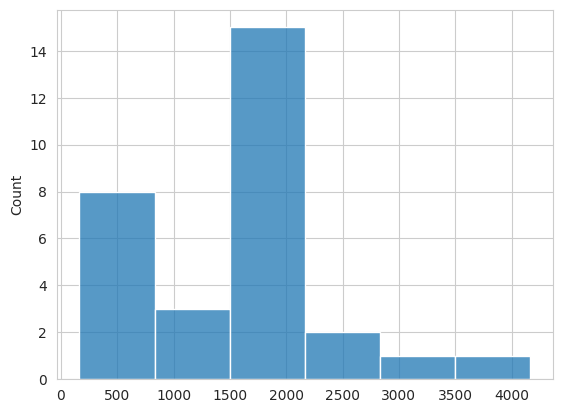

In [8]:
sns.histplot(train_lens)

<Axes: ylabel='Count'>

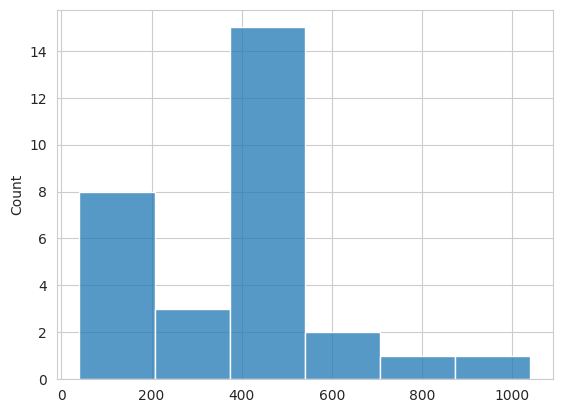

In [9]:
sns.histplot(test_lens)

In [10]:
results = run_flsc(conf, train, test) if conf.algorithm.lower() in ["ifca", "flsc"] else run_fedprox(conf, train, test)

Clients per round: 30


Round:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results = results.as_dataframe()
results

In [ ]:
df = results.query("variable == 'loss'")

In [ ]:
sns.lineplot(df, x="round", y="value", hue="stage").set(title="Losses", ylabel="loss")

In [ ]:
df = results.query("stage == 'test' and variable == 'f1'")

In [ ]:
sns.lineplot(df, x="round", y="value").set(title="F1 score on test data", ylabel="macro F1 score")

In [ ]:
df = results.pivot(values="value", index=["round", "client", "stage"], columns="variable")\
    .reset_index()

df["cluster_identities"] = df["cluster_identities"].astype(int)

df = df.query("stage == 'test'")\
    .drop(columns=["stage", "client"])\
    .groupby(["round", "cluster_identities"])\
    .mean()\
    .reset_index()

In [ ]:
sns.lineplot(df, x="round", y="f1")

In [ ]:
df = results.pivot(values="value", index=["round", "client", "stage"], columns="variable")\
    .reset_index()

df["cluster_identities"] = df["cluster_identities"].astype(int)

df = df.query("stage == 'train'")\
    .drop(columns=["stage", "client"])\
    .groupby(["round", "cluster_identities"])\
    .size()\
    .reset_index()\
    .rename(columns={0: "count"})

In [ ]:
df 

In [ ]:
import plotly.express as px
px.area(df, x="round", y="count", color="cluster_identities")